In [3]:
import math
import random
import scipy
import matplotlib.pyplot as plt
import mpmath as mp
import sklearn
import cvxpy as cp
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import curve_fit
from scipy.spatial.distance import cdist, pdist, squareform
from statsmodels.tsa.stattools import adfuller

import time
from tqdm import tqdm

import torch
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch import nn, autograd, distributions, optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.nn import parallel, utils
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [4]:
from GANF.models.NF import MAF, RealNVP
from rebuild import rebuild, to_padded, from_padded

# Data preprocessing, analysis and utilities

(8756, 5) (8755, 46, 5) (8703, 45, 5)
8756 46 5
(8710, 8756, 5)


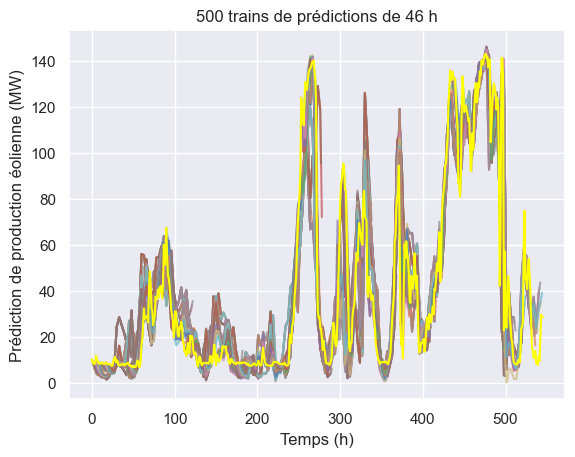

In [6]:
# Load transformed data

npz = np.load('npdata.npz')
#update_ori = np.load('data/update_ori.npy')
uporibis = np.load('upori.npy') # without interpolation so better quality for learning
obs_arr = npz['obs']
updates = npz['up']
print(obs_arr.shape, updates.shape, uporibis.shape)

def plot_trains(padx, obs=obs_arr, step=500):
    for k in range(step):
        plt.plot(padx[k, :, 0], alpha=0.7)
    plt.plot(obs_arr[:step+46, 0], c='yellow')
    plt.xlabel('Temps (h)')
    plt.ylabel('Prédiction de production éolienne (MW)')
    plt.title(f'{step} trains de prédictions de 46 h')

data_arr = rebuild(obs_arr, updates)
padded_data = to_padded(data_arr)
print(padded_data.shape)

plot_trains(padded_data, obs_arr)

Text(0.5, 1.0, "1594 trains d'updates stochastiques de prédiction de 45 h")

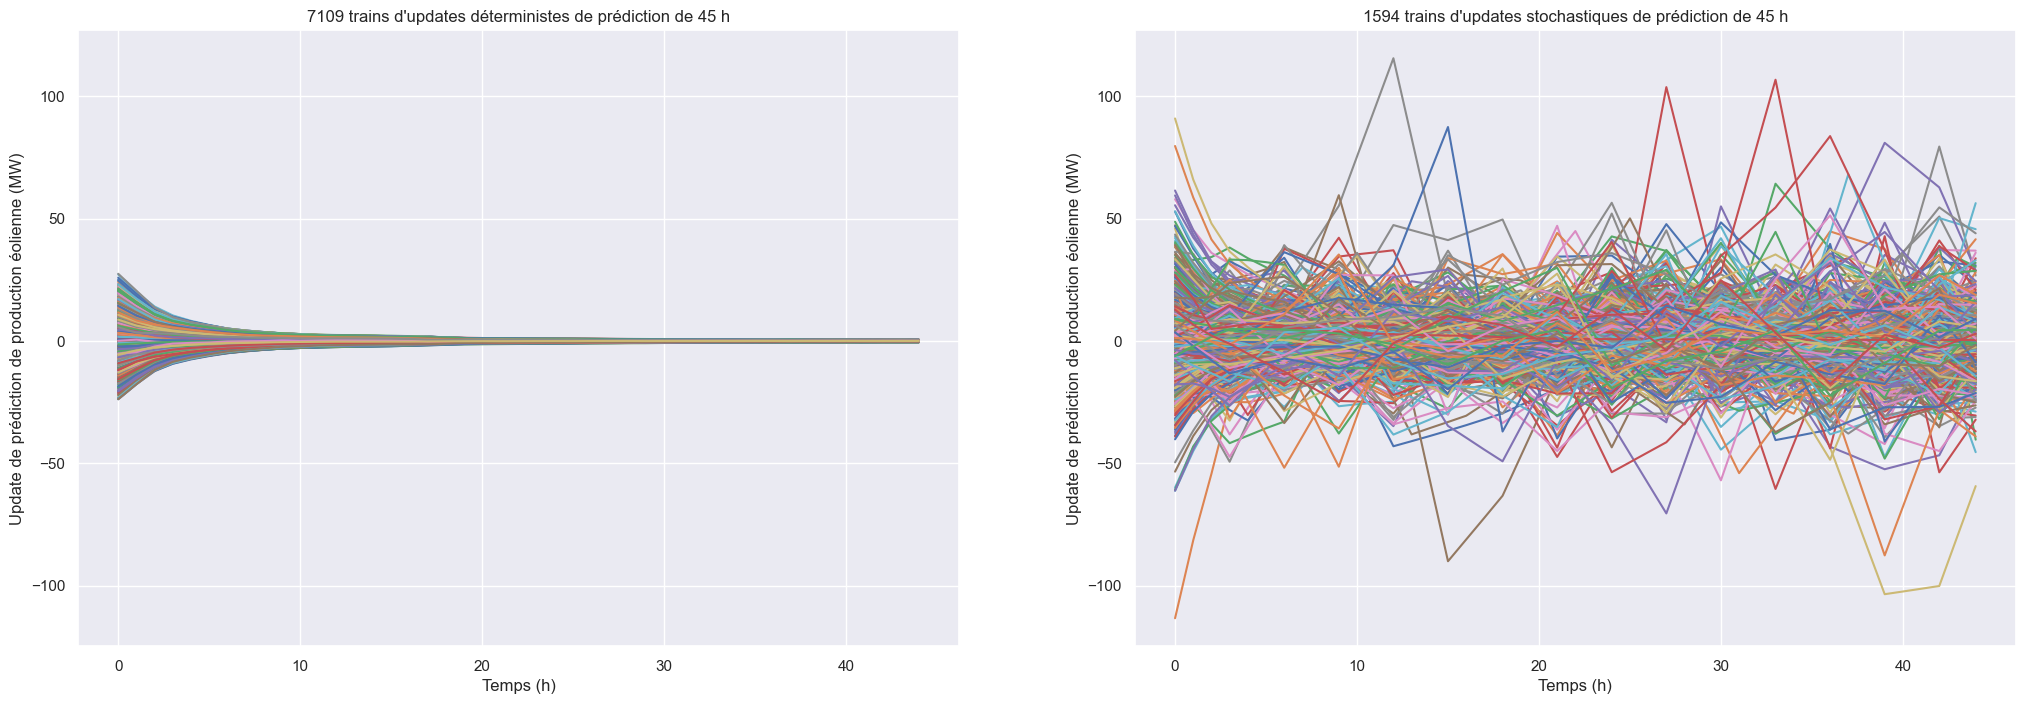

In [7]:
# Clean separation of classes ("big and small uporibis")

critvar = lambda x: np.var(x[10:, 0])

n, m, d = uporibis.shape
listvar = np.array([critvar(uporibis[k, :, :]) for k in range(n)])

indsmall = np.argwhere(listvar < 0.5).squeeze()
nsmall = indsmall.shape[0]
upsmall = uporibis[indsmall, :, :]
indbig = np.argwhere(listvar >= 0.5).squeeze()
nbig = indbig.shape[0]
upbig = uporibis[indbig, :, :]

plt.figure(figsize=(25, 8))
ax1 = plt.subplot(1, 2, 1)
for k in range(nsmall):
    plt.plot(upsmall[k, :, 0])
plt.xlabel('Temps (h)')
plt.ylabel('Update de prédiction de production éolienne (MW)')
plt.title(f'{nsmall} trains d\'updates déterministes de prédiction de 45 h')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
for k in range(nbig):
    plt.plot(upbig[k, :, 0])
plt.xlabel('Temps (h)')
plt.ylabel('Update de prédiction de production éolienne (MW)')
plt.title(f'{nbig} trains d\'updates stochastiques de prédiction de 45 h')

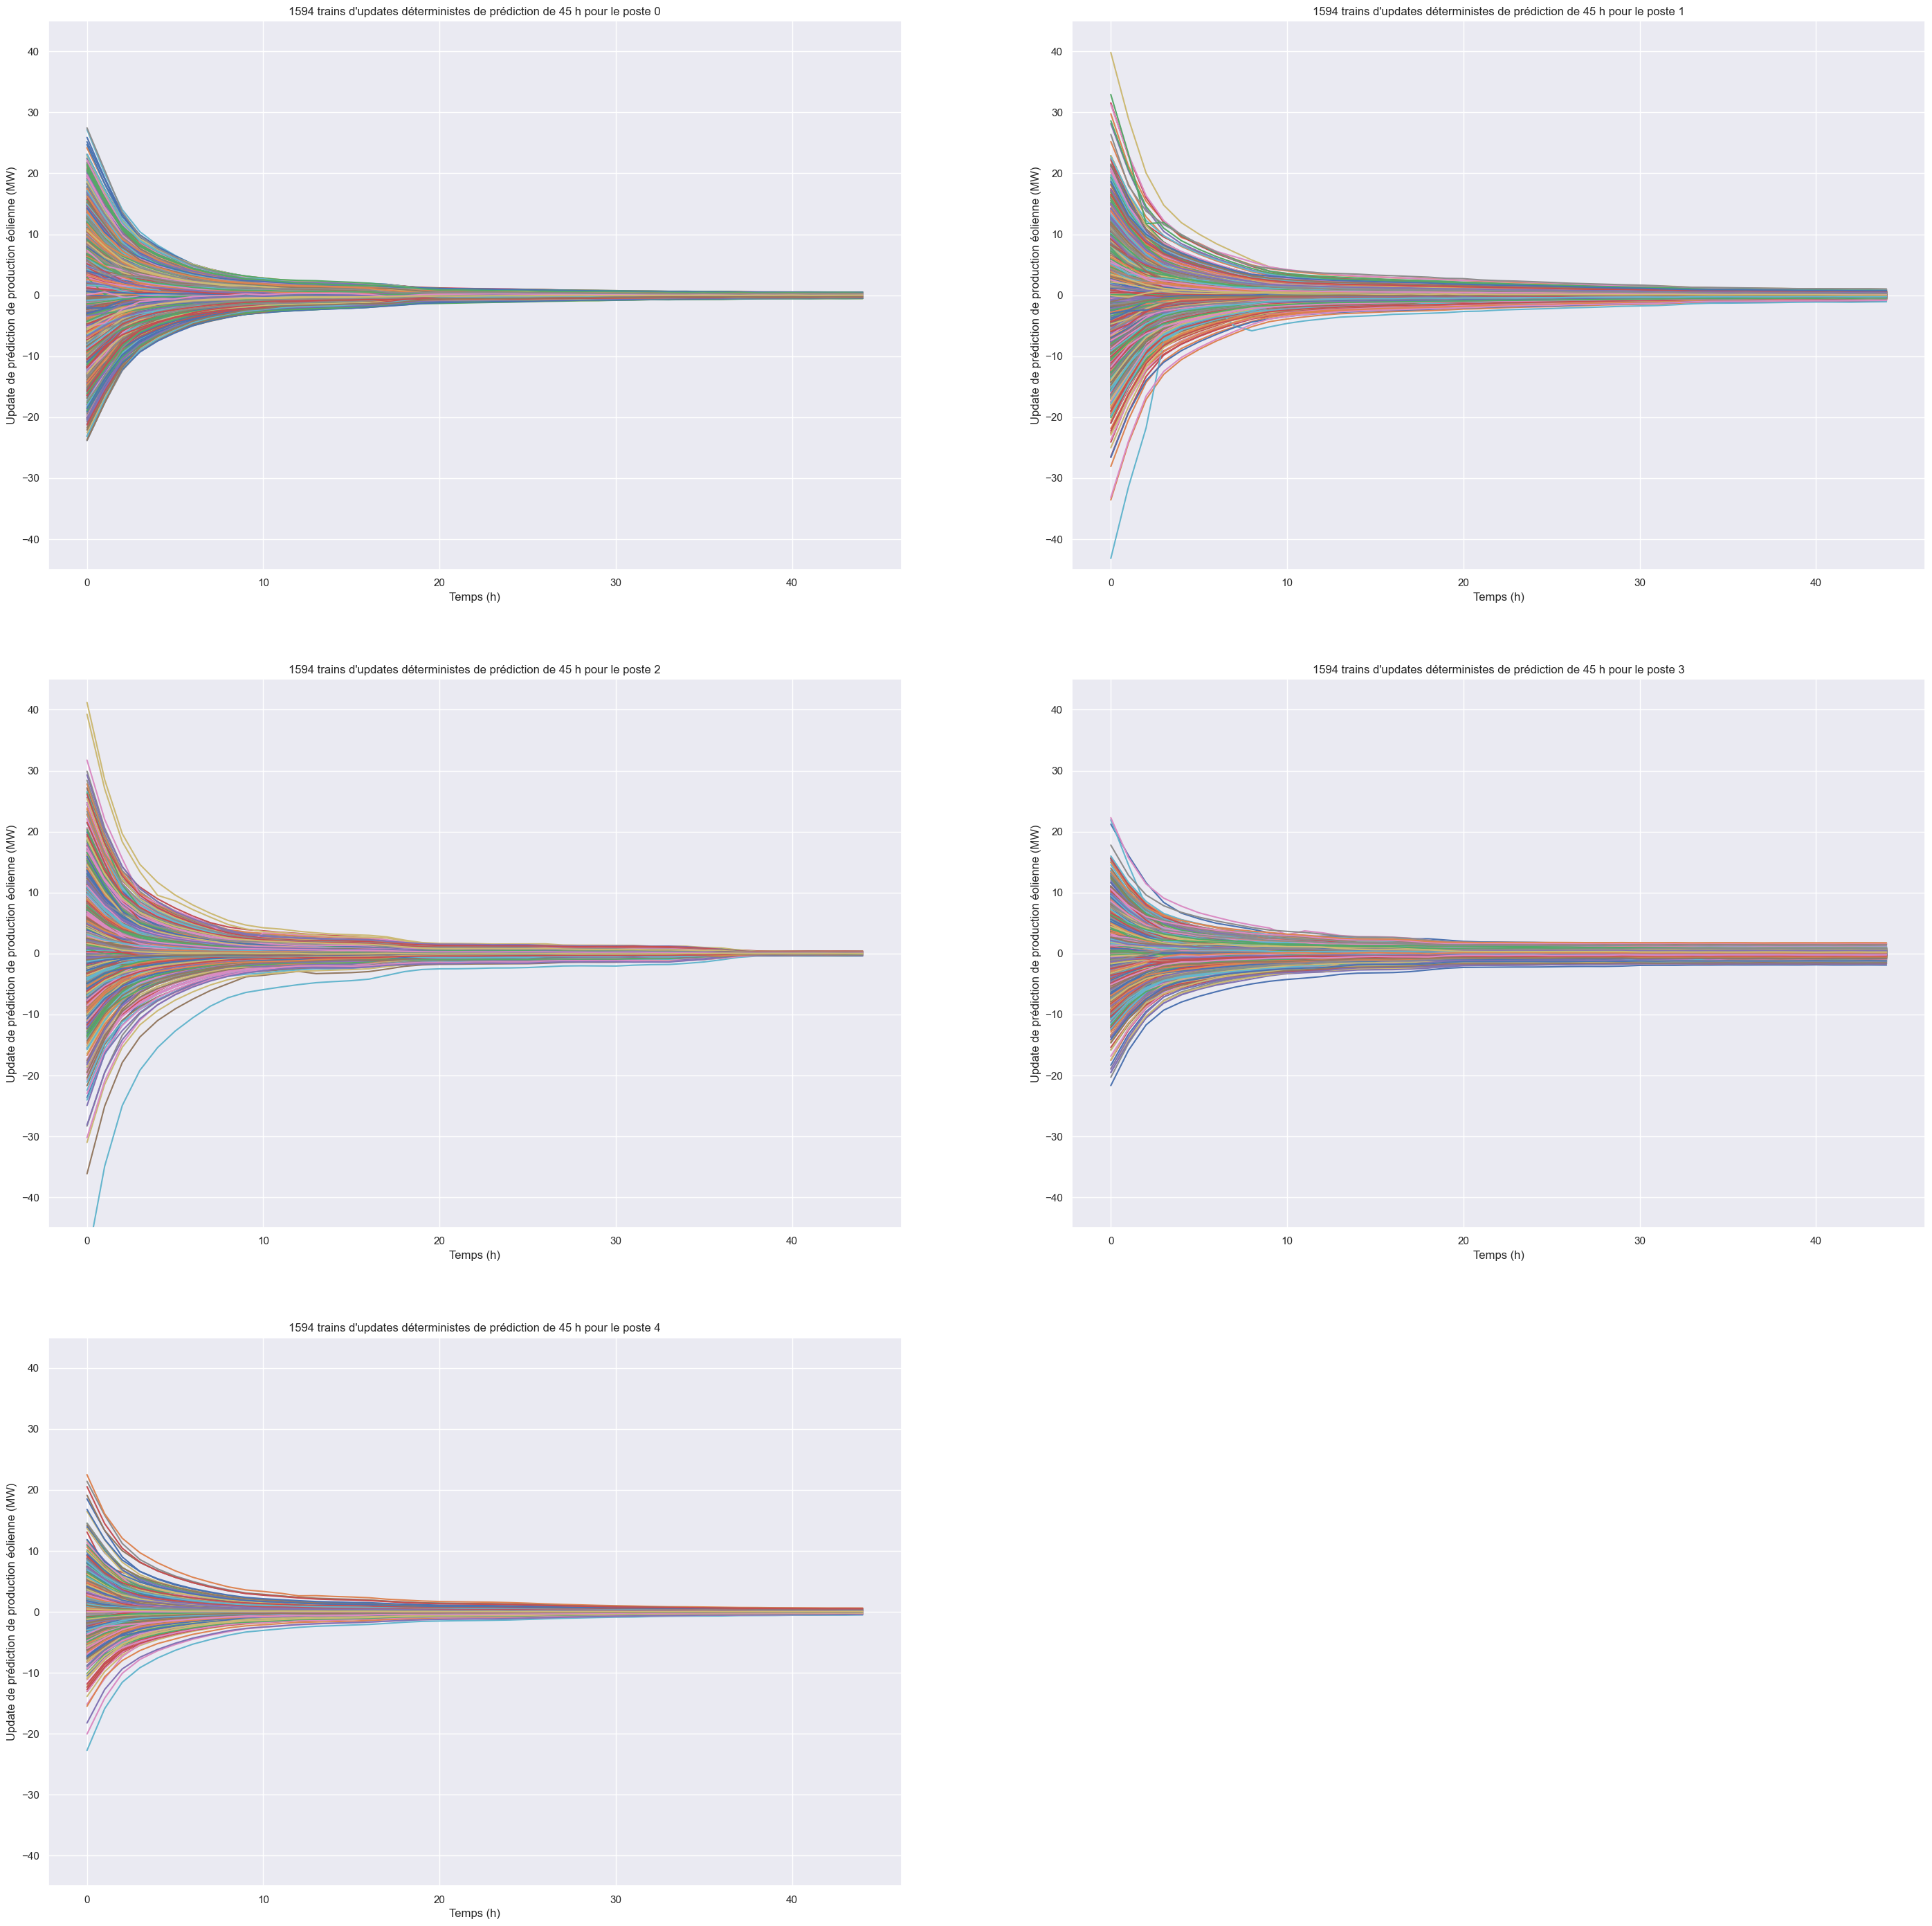

In [8]:
plt.figure(figsize=(35, 35))
for i in range(d):
    plt.subplot(3, 2, i+1)
    for k in range(nsmall):
        plt.plot(upsmall[k, :, i])
    plt.ylim(-45, 45)
    plt.xlabel('Temps (h)')
    plt.ylabel(f'Update de prédiction de production éolienne (MW)')
    plt.title(f'{nbig} trains d\'updates déterministes de prédiction de 45 h pour le poste {i}')

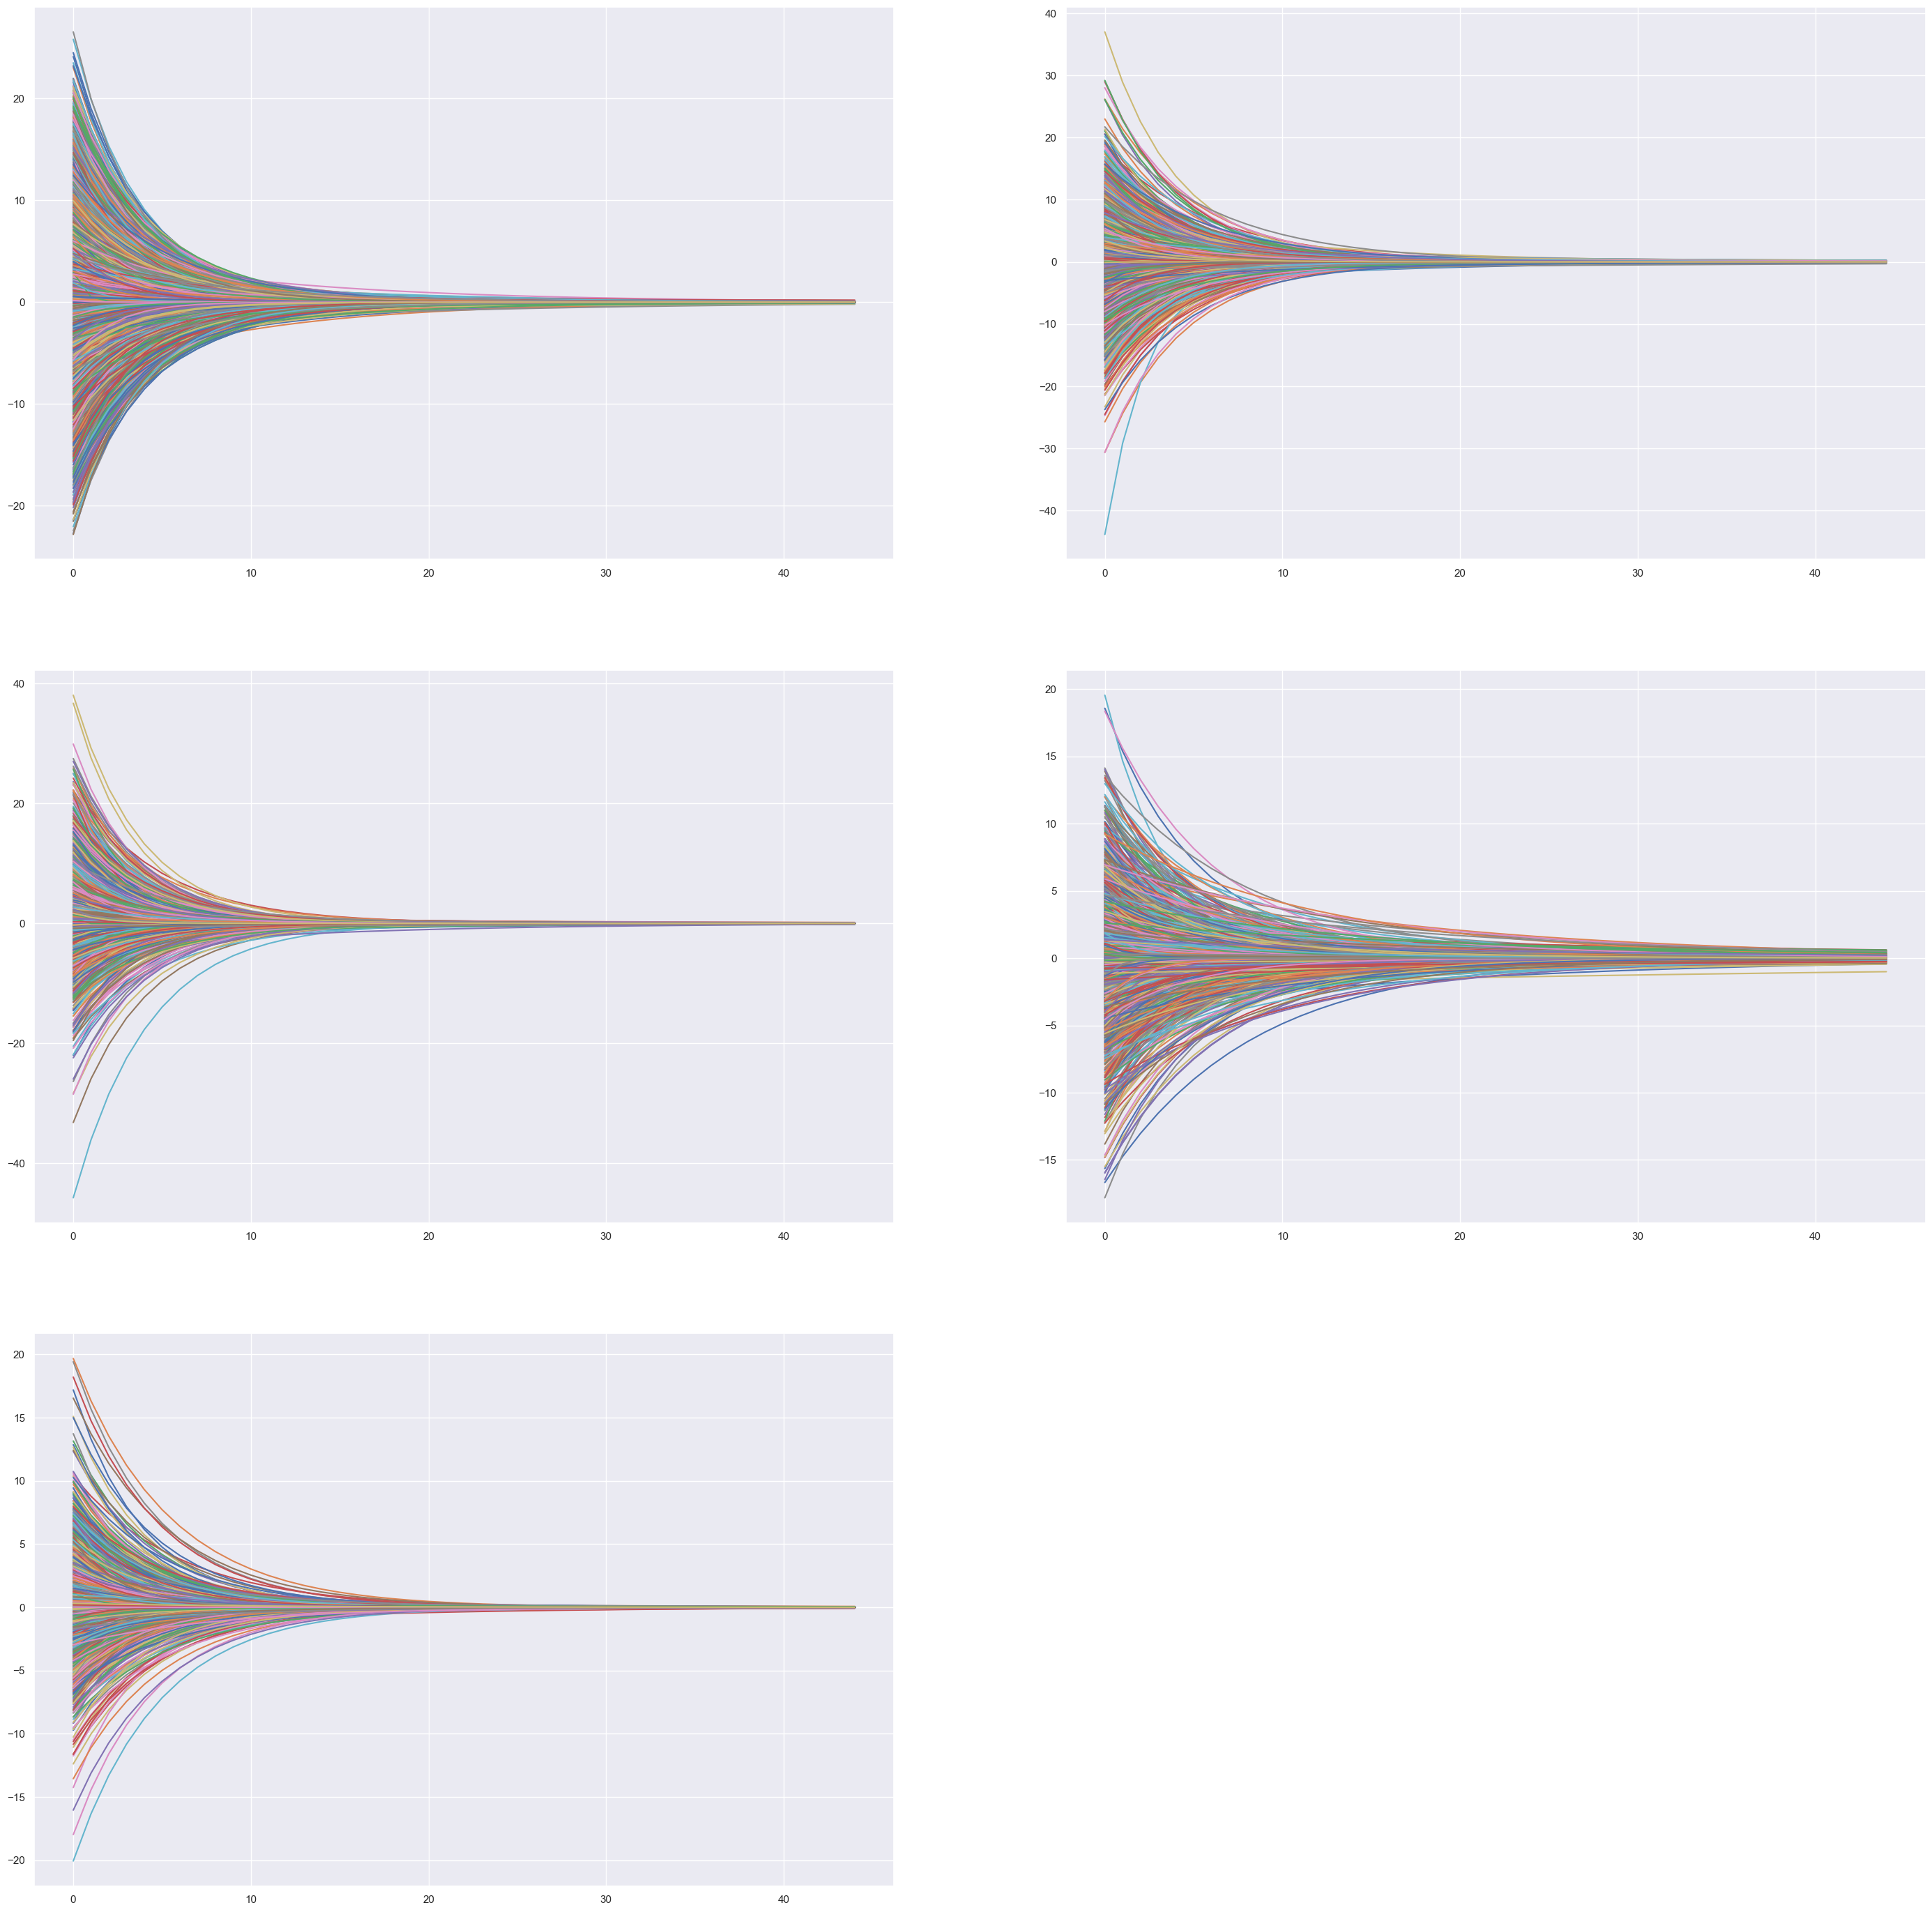

In [9]:
# Modèle paramétrique exponentiel pour les updates déterministes

def fexp(x, a, b):
    return b*np.exp(a*x)

xdata = np.arange(m)

plt.figure(figsize=(35, 35))

plist_tot = []
for j in range(d):
    plist = []
    plt.subplot(3, 2, j+1)
    for k in range(nsmall):
        ydata = upsmall[k, :, j]
        popt, _ = curve_fit(fexp, xdata, ydata, bounds=([-10, -50], [0, 50]))
        plist.append(popt)
        plt.plot(xdata, fexp(xdata, popt[0], popt[1]))
    plist_tot.append(plist)

In [10]:
plist1_tot, plist2_tot = [], []
for j in range(d):
    plist = plist_tot[j]
    plist1, plist2 = [plist[k][0] for k in range(nsmall)], [plist[k][1] for k in range(nsmall)]
    plist1_tot.append(plist1); plist2_tot.append(plist2)

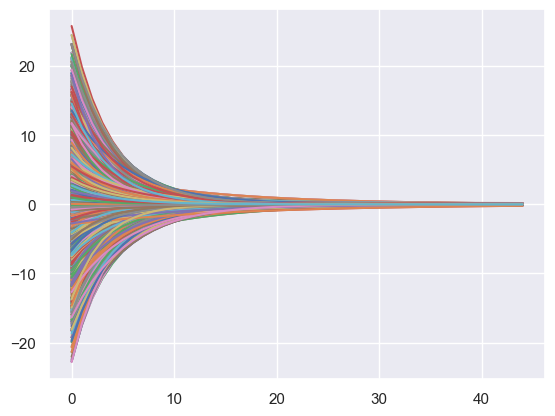

In [11]:
def parametric_generator(nb=10000):
    traj_det = np.zeros((nb, m, d))
    #rd = np.random.choice(len(plist), size=nb*d, replace=True)
    for i in range(d):
        plist1, plist2 = plist1_tot[i], plist2_tot[i]
        for j in range(nb):
            k1, k2 = np.random.choice(len(plist)), np.random.choice(len(plist))
            traj_det[j, :, i] = plist2[k1]*np.exp(plist1[k1]*xdata)

    return traj_det

taille = 1280*5
traj_det = parametric_generator(taille)

for k in range(taille):
    plt.plot(traj_det[k, :, 0])

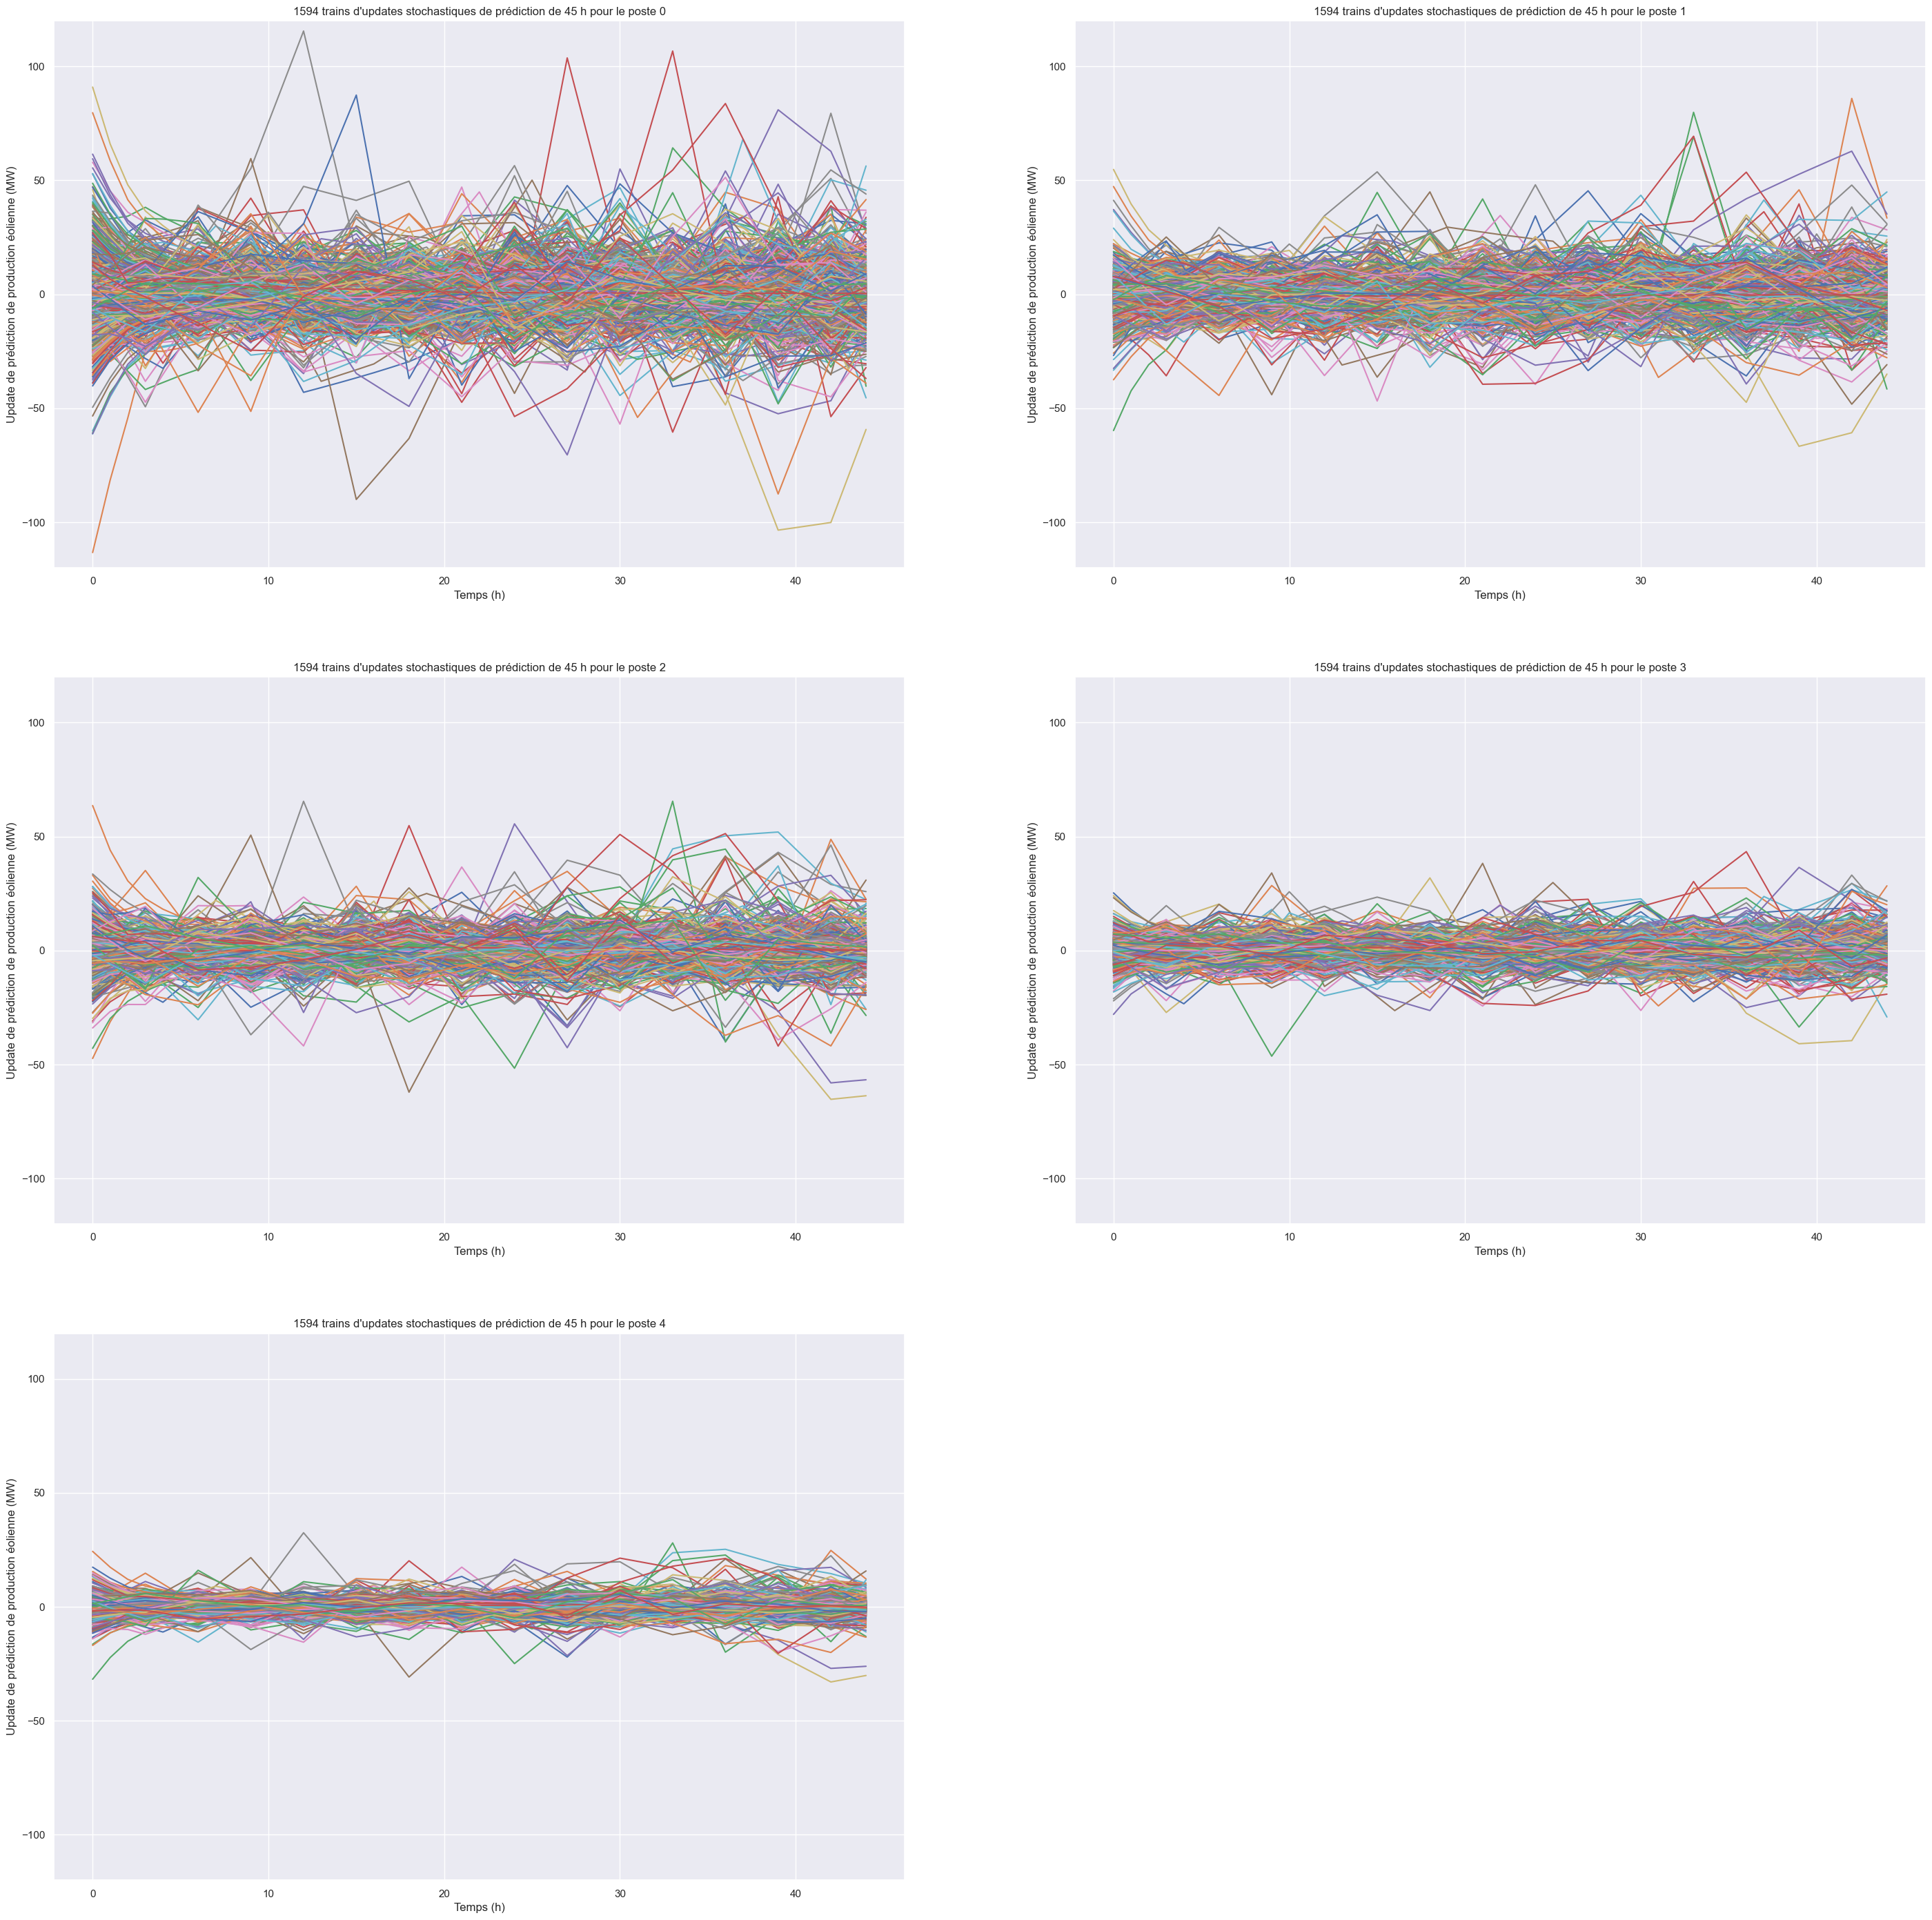

In [12]:
# Normalisation pour les updates stopchastiques

plt.figure(figsize=(35, 35))
for i in range(5):
    plt.subplot(3, 2, i+1)
    for k in range(nbig):
        plt.plot(upbig[k, :, i])
    plt.ylim(-120, 120)
    plt.xlabel('Temps (h)')
    plt.ylabel(f'Update de prédiction de production éolienne (MW)')
    plt.title(f'{nbig} trains d\'updates stochastiques de prédiction de 45 h pour le poste {i}')

In [13]:
factors = np.max(np.max(np.abs(upbig), axis=0), axis=0)
print(factors)

upbig_scaled = upbig / np.max(factors)

upbig_stack_norm = np.vstack([upbig[:, :, i]/factors[i] for i in range(d)])
print(upbig_stack_norm.shape)

[115.54  85.97  65.52  46.37  33.01]
(7970, 45)


# Torch models and utils

In [14]:
# Setting the seed
pl.seed_everything(12)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Global seed set to 12


Device cpu


## MAF

## Deep GPVAR

In [15]:
def torch_xt(z, data=torch.tensor(upbig_scaled).to(device)):
    N, T, D = data.shape
    delta = (1 / (torch.sqrt(np.pi * torch.log(torch.tensor(N)))*4*(N**0.25))).to(device)
    empirical_cdf_tabularx = torch.zeros((z.shape[0], T, D)).to(device)

    for i in range(T):
        for j in range(D):
            fi = torch.sum(data[:, i, j].unsqueeze(0) <= z[:, i, j].unsqueeze(1).to(device), dim=1) / N
            fi = torch.clip(fi, delta, 1 - delta)
            empirical_cdf_tabularx[:, i, j] = fi


    phi = distributions.Normal(loc=0, scale=1)
    norm_icdf_empir_tabx = phi.icdf(empirical_cdf_tabularx)

    return norm_icdf_empir_tabx.to(device)


def invtorch(x, t, data=torch.tensor(upbig_scaled).to(device)):
    phi = distributions.Normal(loc=0, scale=1)
    norm_z = phi.cdf(x)
    inv_emp_tabularx = torch.zeros_like(norm_z)

    for j in range(data.shape[-1]):
        m = torch.tensor(data[:, t, j].shape[0])
        Nlist = m*norm_z[:, j]
        data_sort, indices = torch.sort(data[:, t, j])
        for k, N in enumerate(Nlist):
            N = int(N)
            if N < data[:, t, j].shape[0]:
                inv_emp_tabularx[k, j] = data_sort[N]
            else:
                inv_emp_tabularx[k, j] = data_sort[N-1]

    return inv_emp_tabularx

In [16]:
class DGPVAR(nn.Module):
    def __init__(self, input_size=d, hidden_size=2*d, num_layers=2, dropout=0.1, batch_size=16, seq_len=m, rank=d):
        super(DGPVAR, self).__init__()

        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.rank = rank

        ndim = int(hidden_size // input_size)
        self.ndim = ndim
        self.softplus = nn.Softplus()

        self.mu_weight = nn.Parameter(torch.zeros(ndim))
        self.v_weight = nn.Parameter(torch.zeros(self.rank, ndim))
        self.d_weight = nn.Parameter(torch.zeros(ndim))

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)

    def log_prob(self, z):
        h, _ = self.lstm(z)
        x = torch_xt(z)
        res = torch.zeros((self.batch_size, self.seq_len)).to(device)
        for k in range(self.seq_len):
            ht, zt = h[:, k, :], z[:, k, :]
            htt = ht.view((self.batch_size, self.input_size, self.ndim))
            mut = (htt @ self.mu_weight).to(device)
            vt = (htt @ self.v_weight.T).to(device)
            dt = self.softplus(htt @ self.d_weight).to(device)

            distr = distributions.LowRankMultivariateNormal(loc=mut, cov_factor=vt, cov_diag=dt)
            xt = x[:, k, :]
            res[:, k] = distr.log_prob(xt)

        return res.mean(dim=1)

    def forward(self, z):
        return self.log_prob(z).mean()

    @torch.no_grad()
    def sample(self, number=1):
        h = torch.zeros([number, self.seq_len, self.hidden_size]).to(device)
        h_n = torch.zeros([self.num_layers, number, self.hidden_size]).to(device)
        c = torch.zeros([self.num_layers, number, self.hidden_size]).to(device)
        z = torch.zeros([number, self.seq_len, self.input_size]).to(device)

        for t in range(self.seq_len):
            h, (h_n, c) = self.lstm(z[:, :t+1, :].contiguous(), (h_n, c))

            ht, zt = h[:, t, :], z[:, t, :]
            htt = ht.view((number, self.input_size, self.ndim))
            mut = htt @ self.mu_weight
            vt = htt @ self.v_weight.T
            dt = self.softplus(htt @ self.d_weight)

            distr = distributions.LowRankMultivariateNormal(loc=mut, cov_factor=vt, cov_diag=dt)

            x = distr.sample()
            z[:, t, :] = invtorch(x, t)

        return z

## Temporal conditioned NF

In [17]:
class TNF(nn.Module):
    def __init__(self, input_size=5, hidden_rnn=100, n_blocks=5, hidden_size=4, n_hidden=10, num_layers=2, dropout=0.1, model="MAF", batch_norm=True, batch_size=32, seq_len=m):
        super(TNF, self).__init__()

        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.input_size = input_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_rnn, num_layers=num_layers, batch_first=True, dropout=dropout)
        #self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        #self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        if model=="MAF":
            #self.nf = MAF(n_blocks, input_size, hidden_size, n_hidden, cond_label_size=hidden_size, batch_norm=batch_norm, activation='tanh')
            self.nf = MAF(n_blocks, input_size, hidden_size, n_hidden, cond_label_size=hidden_rnn, batch_norm=batch_norm, activation='relu')

        else:
            self.nf = RealNVP(n_blocks, input_size, hidden_size, n_hidden, cond_label_size=hidden_size, batch_norm=batch_norm)

        self.prior = distributions.normal.Normal(loc=0.0, scale=1.0)

    def log_prob(self, x):
        h,_ = self.rnn(x)
        #print(x.shape, h.shape, 'post rnn')
        #print("next")
        #print("nextnext")
        #print(d.shape, 'd')

        h = h.reshape((-1, h.shape[-1]))
        x = x.reshape((-1, x.shape[-1]))
        try:
            res = self.nf.log_prob(x, h).reshape([x.shape[0], -1])
            return res.mean(dim=1)
        except:
            return -1e8 * torch.ones(10, requires_grad=True).to(device)
    
    def forward(self, x):
        return self.log_prob(x).mean()
    
    @torch.no_grad()
    def sample(self, z_init=None, number=1):
        if z_init is None:
            z = self.prior.sample(sample_shape=torch.Size([number, self.seq_len, self.input_size])).to(device)
        else:
            z = z_init.to(device)


        h = torch.zeros([number, self.seq_len, self.hidden_size]).to(device)
        h_n = torch.zeros([self.num_layers, number, self.hidden_size]).to(device)
        c = torch.zeros([self.num_layers, number, self.hidden_size]).to(device)
        x = torch.zeros([number, self.seq_len, self.input_size]).to(device)

        for t in range(self.seq_len):
            #h, h_n = self.rnn(x[:, :t+1, :].contiguous(), h_n.contiguous())
            h, (h_n, c) = self.rnn(x[:, :t+1, :].contiguous(), (h_n, c))
            x_t, _ = self.nf.inverse(z[:, t, :], h[:, t, :])  # Generate sample for current time step
            x[:, t, :] = x_t  # Store the generated sample in the x tensor


        return x


In [18]:
odict = {'lr': 1e-3, 'weight_decay': 0}

hdict_nf = {"input_size":225, "n_blocks":3, "hidden_size":8, "n_hidden":1, "batch_norm":True}

hdict_dgp = {"input_size":d, "hidden_size":2*d, "num_layers":2, "dropout":0.1, "batch_size":16, "seq_len":m, "rank":d}

hdict_tnf = {"input_size":d, "hidden_rnn":100, "n_blocks":5, "hidden_size":4, "n_hidden":10, "num_layers":2, "dropout":0.1, "model":"MAF", 
         "batch_norm":True, "batch_size":32, "seq_len":m}

model_dict = {"Copula": [DGPVAR, hdict_dgp], "NF": [MAF, hdict_nf], "RNN-NF": [TNF, hdict_tnf]}

In [19]:
def train_model(trainloader, testloader, model_name="Copula", hparams=None, opt_hparams=odict, n_epochs=50):

    if hparams != None:
        model = model_dict[model_name][0](**hparams).to(device)
    else:
        model = model_dict[model_name][0](**model_dict[model_name][1]).to(device)

    optimizer = optim.Adam(list(model.parameters()), **opt_hparams)
    errtr = []
    errte = []

    for epoch in tqdm(range(n_epochs)):
        # train
        err_tr = []
        model.train()
        for x in trainloader:
            x = x.to(device)
            loss = -model.log_prob(x).mean()
            err_tr.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            # compute error on test set
            err_te = []
            model.eval()
            for x in testloader:
                x = x.to(device)
                loss = -model.log_prob(x).mean()
                err_te.append(loss.item())

        errtr.append(np.mean(err_tr)/np.log(2))
        errte.append(np.mean(err_te)/np.log(2))
            

    plt.plot(errtr, label='training_loss')
    plt.plot(errte, label='validation_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    return model, errtr, errte

# Torch wrapping and training

In [20]:
def load_power(data, batch_size=128, stack=False):

    #train_df = data[:int(0.8*len(data))]
    #test_df = data[int(0.8*len(data)):]
    train_df, test_df = train_test_split(data, test_size=0.2)
    
    #n_stations = data[0].shape[1]
    #n_window = data[0].shape[0]
    
    train_loader = DataLoader(Power(train_df, stack=stack), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
    test_loader = DataLoader(Power(test_df, stack=stack), batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False, drop_last=True)

    return train_loader, test_loader#, n_stations, n_window

class Power(Dataset):
    def __init__(self, data, stack):
        super(Power, self).__init__()
        self.data = data
        self.stack = stack

    def __len__(self):
        length = self.data.shape[0]
        return length

    def __getitem__(self, idx):
        #data = self.data[index].reshape([self.n_window, -1, 1])
        if self.stack:
            data = self.data[idx].T.reshape(-1)
        else:
            data = self.data[idx]
            
        return torch.FloatTensor(data)#.transpose(0,1)

In [21]:
#trainloader, testloader = load_power(upbig_stack_norm, 16)
trainloader, testloader = load_power(upbig_scaled, 16)
input = next(iter(trainloader))
print(input.shape, len(trainloader))

torch.Size([16, 45, 5]) 79


In [22]:
model_dict['Copula'][0](**model_dict['Copula'][1])

DGPVAR(
  (softplus): Softplus(beta=1, threshold=20)
  (lstm): LSTM(5, 10, num_layers=2, batch_first=True, dropout=0.1)
)

100%|██████████| 25/25 [05:50<00:00, 14.00s/it]


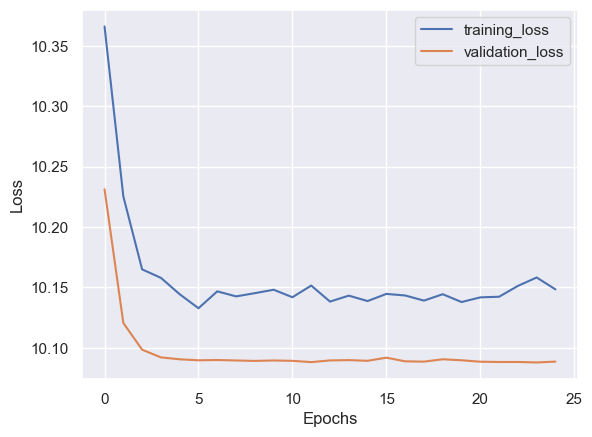

In [27]:
model = train_model(trainloader=trainloader, testloader=testloader, model_name='Copula', n_epochs=25)

# Generation and reconstruction

In [23]:
def generate(trained_model, number=1280, model_name='Copula'):

    if model_name == 'NF': # pour l'instant on suppose 1d avec ce modèle
        prior = distributions.normal.Normal(loc=0.0, scale=1.0)
        u = prior.sample(sample_shape=torch.Size([number, m])).to(device)
        ress = trained_model.inverse(u)
        res = ress[0].detach().cpu().numpy()
        assert(res.shape == (number, m))

    elif model_name == 'Copula': # on suppose d dimensions
        res = trained_model.sample(number=number).detach().cpu().numpy()
        assert(res.shape == (number, m, d))

    elif model_name == 'RNN-NF':
        res = trained_model.sample(number=number).squeeze().cpu().detach().numpy()
        assert(res.shape == (number, m, d))

    return res

In [24]:
def rebuild_cuis(obs_data, updates_gen):
    """
    Yields forecast trajectories from a given observation dataset and generated prediction updates
    args:
    obs_data: array of shape (n_samples, dimension), e.g. full year of observations 1h sampled
    updates_gen: array of shape (n_samples, seq_size, dimension), e.g. series of updates for 45h datapoints per sample
    return: array of shape (n_samples-seq_size, seq_size, dimension)
    """
    n, m, d = updates_gen.shape
    n += 1
    #print(n, m, d)
    up_padded =  to_padded(updates_gen, zero=True)
    traj_rebuilt = np.zeros((n-m, n, d))

    for i in range(n-m):
        for j in range(i, i+m):
            for p in range(d):
                traj_rebuilt[i, j, p] = min(150, max(0, obs_data[j, p] - sum([up_padded[k, j, p] for k in range(i, j)])))

    res = from_padded(traj_rebuilt)
    return res


def rassemble(up1, up2):
    resgen = []
    k, k1, k2 = 0, 0, 0
    while k2 < up2.shape[0] and k1 < up1.shape[0]:
        if (k - 5)%6 != 0:
            resgen.append(up1[k1])
            k1 += 1
        else:
            resgen.append(up2[k2])
            k2 += 1
        k += 1

    return np.array(resgen)

In [25]:
def gen_traj(trained_model, n_scenarios = 1, model_name='Copula', obs=obs_arr):

    n1 = int(obs.shape[0] * (1 - 1/6)) * n_scenarios
    n2 = int(obs.shape[0] / 6) * n_scenarios

    # Generate the right number of determinist and stochastic updates
    up_det = parametric_generator(n1)
    up_sto = generate(trained_model=trained_model, number=n2, model_name=model_name)
    assert(up_det.shape[1:] == up_sto.shape[1:])

    # Adjust the amplitude of the stochastic updates according to the dimension
    up_sto = factors * up_sto / np.max(np.max(np.abs(up_sto), axis=0), axis=0)

    # Combine them
    up_tot = rassemble(up_det, up_sto)

    # Build the trajectory (respecting the physical constraints)
    ntot = up_tot.shape[0]
    resf = []
    for k in range(n_scenarios):
        resf.append(rebuild_cuis(obs, up_tot[k*ntot//n_scenarios:(k+1)*ntot//n_scenarios]))

    if n_scenarios == 1:
        return resf[0]
    else:
        return resf

In [29]:
try1 = gen_traj(trained_model=model[0])

(8710, 8755, 5)


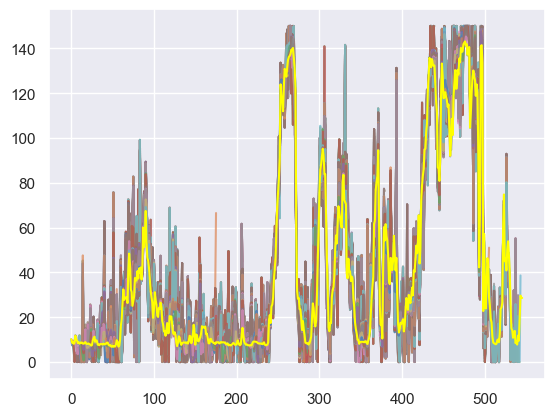

In [30]:
padded_pred = to_padded(try1)
print(padded_pred.shape)
for k in range(500):
    plt.plot(padded_pred[k, :, 0], alpha=0.7)
plt.plot(obs_arr[:546, 0], c='yellow')

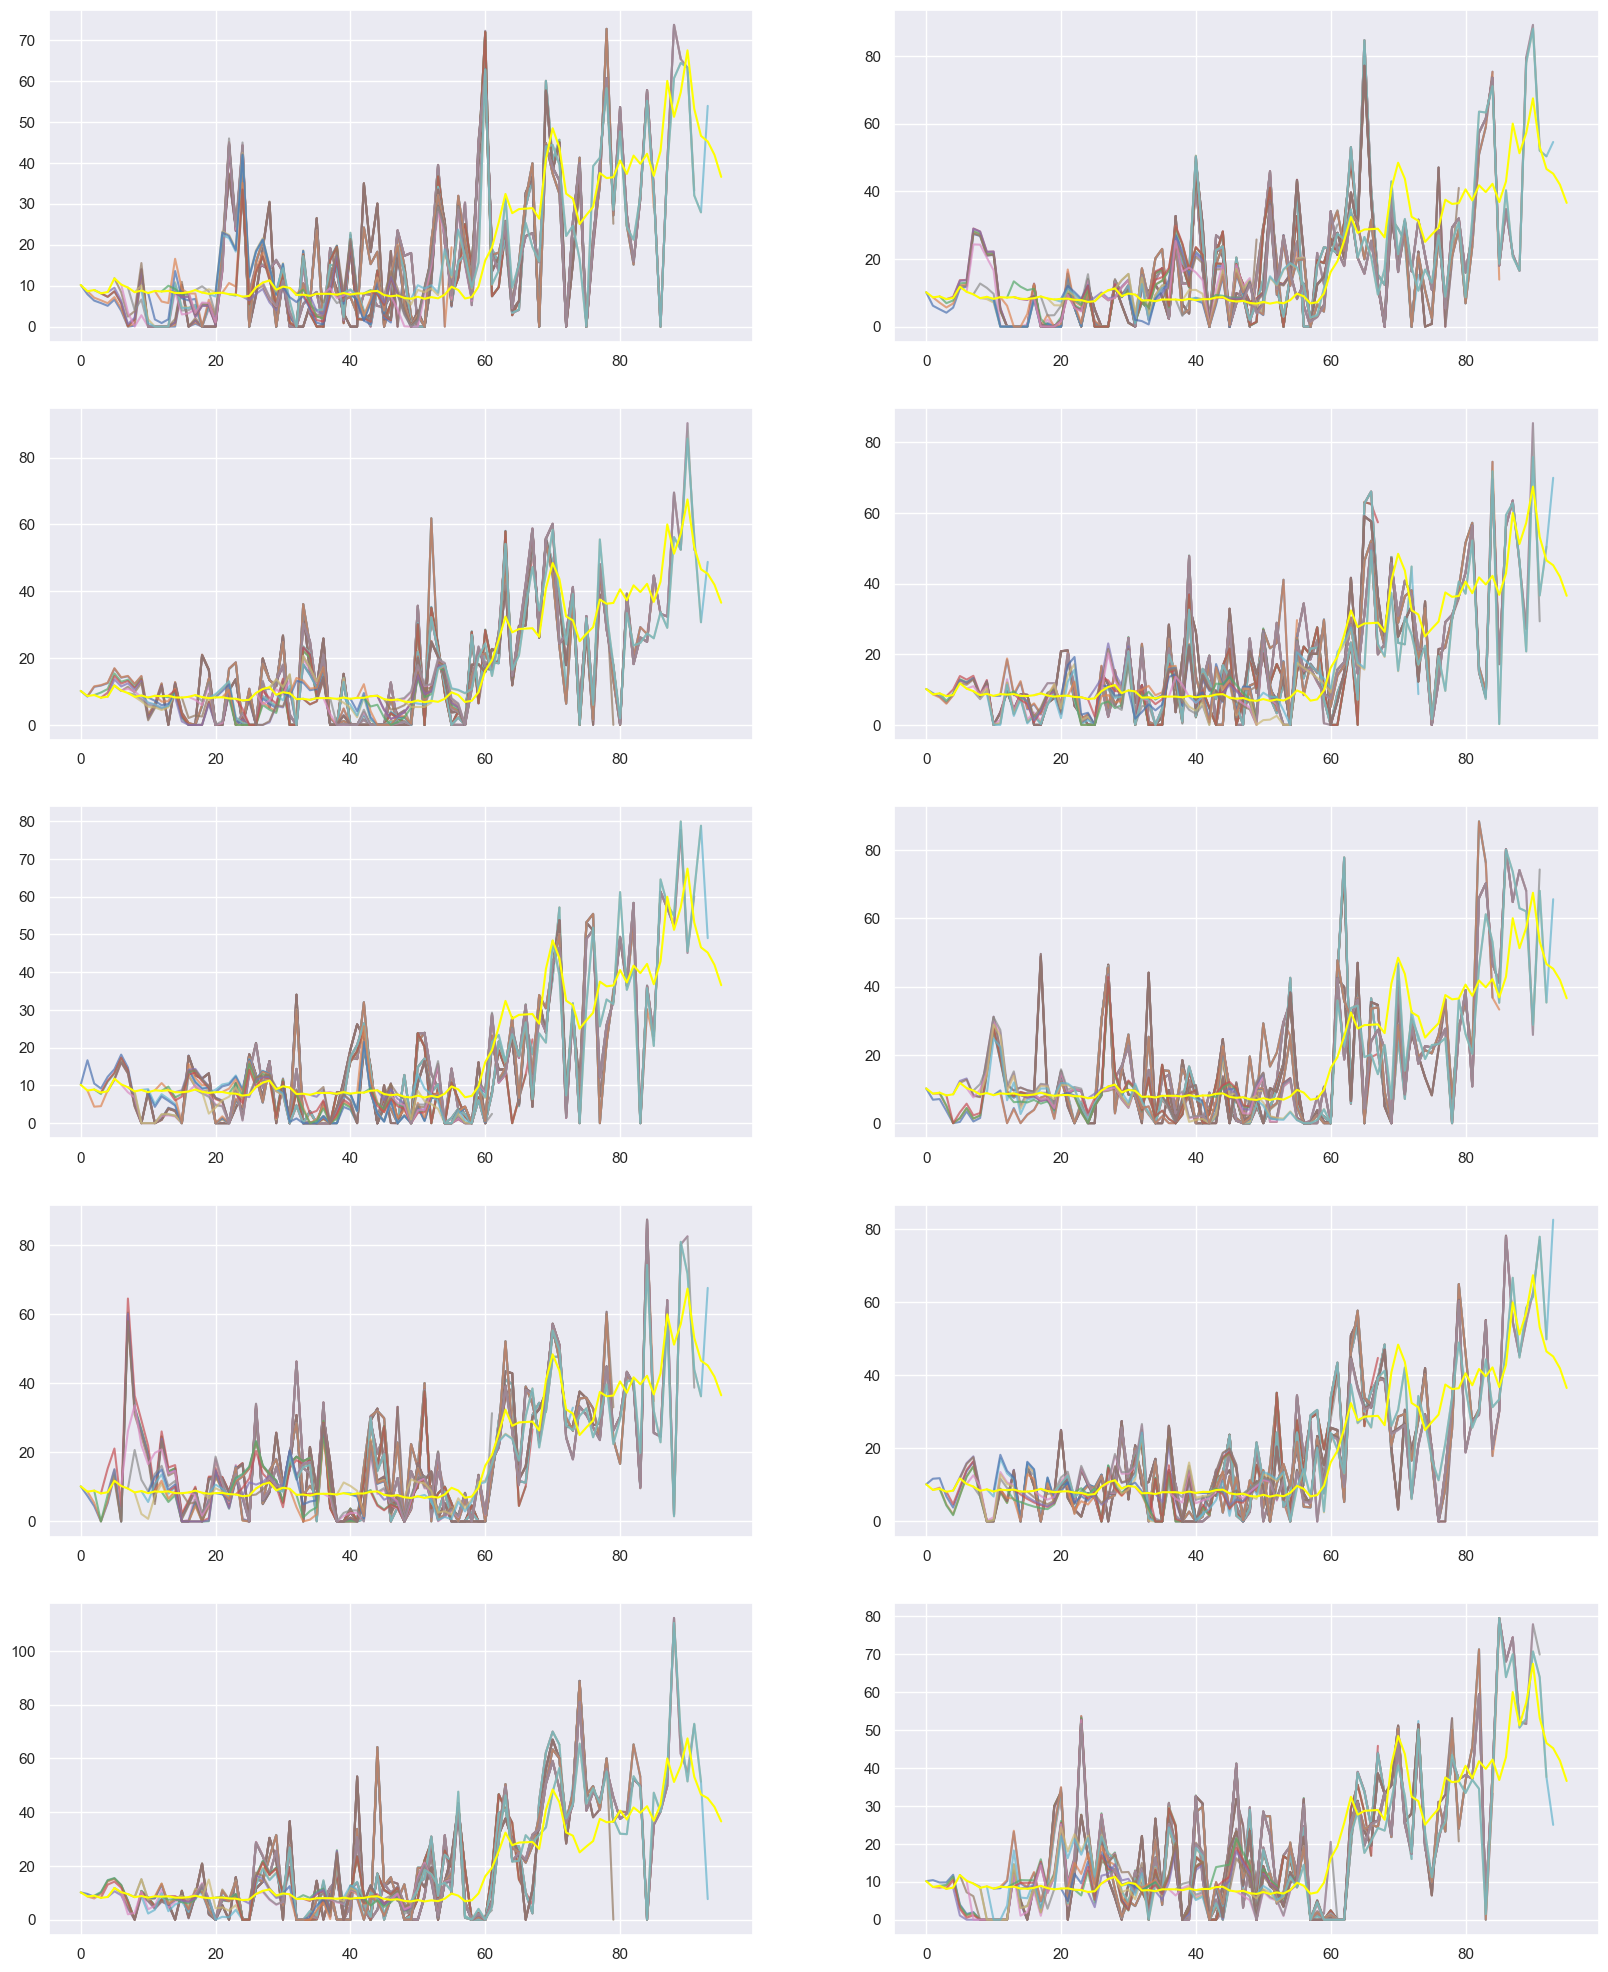

In [31]:
trylist = gen_traj(trained_model=model[0], n_scenarios=10)
trypad = [to_padded(x) for x in trylist]

plt.figure(figsize=(20, 25))

for p in range(10):
    plt.subplot(5, 2, p+1)
    for k in range(50):
        plt.plot(trypad[p][k, :, 0], alpha=0.7)
    plt.plot(obs_arr[:96, 0], c='yellow')

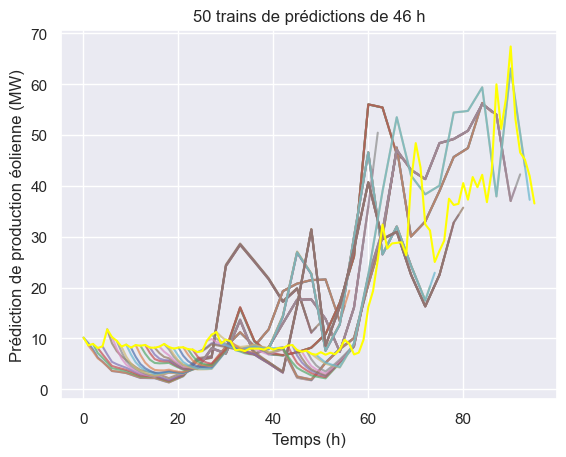

In [32]:
plot_trains(padded_data, obs_arr, step=50)

# Plot and evaluation

In [33]:
def MiVo(x, y, metric='euclidean'):
    """
    x: ndarray (n_samples, n_seq) real data
    y: ndarray (n_samples, n_seq) generated data
    Returns a score for the generative model for time series (the lower the better)
    """

    # Construct and plot distance matrix
    distance_matrix = cdist(x, y, metric=metric)  # condensed distance matrix
    sns.heatmap(distance_matrix)
    plt.show()

    # Computes the score
    # d1 set of minimal distances for all generated time series, i.e. is it realistic?
    # d2 set of minimal distances for all real time series, i.e. is it diverse?
    d1, d2 = np.amin(distance_matrix, axis=1), np.amin(distance_matrix, axis=0)
    mu, var = np.mean(d1), np.var(d2)
    return mu + var

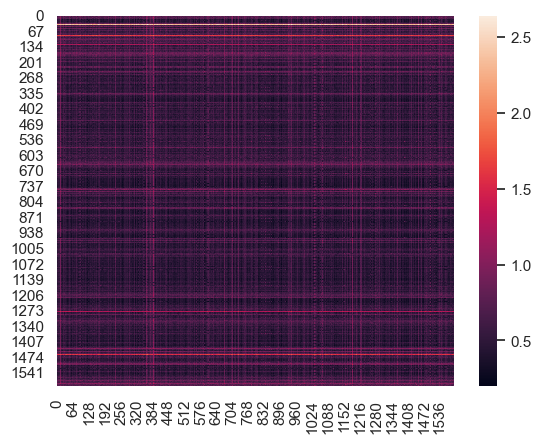

0.39890979815016525

In [35]:
MiVo(upbig_scaled[:, :, 0], generate(trained_model=model[0], number=nbig)[:, :, 0])

In [42]:
def crps_nrg_marginal(y_true, y_sampled):
    """
    Compute the CRPS NRG for a given time period k -> the CRPS is a univariate metric.
    Therefore it has to be computed per marginal.
    :param y_true: true value for this time period.
    :param y_sampled: nb quantile/scenarios for time period k with shape(nb,)
    """
    nb = y_sampled.shape[0] # Nb of quantiles/scenarios sampled.
    simple_sum = np.sum(np.abs(y_sampled - y_true)) / nb
    double_somme = 0
    for i in range(nb):
        for j in range(nb):
            double_somme += np.abs(y_sampled[i] - y_sampled[j])
    double_sum = double_somme / (2 * nb * nb)

    crps = simple_sum  - double_sum

    return crps


def energy_score(y_true, y_sampled):
    """
    Se calcule train par train en une dimension ?
    :param y_true: true historical forecast.
    :param y_sampled: array of generated forecasts for the same time period shape nb_scenarios x n_seq
    """
    nb = y_sampled.shape[0] # Nb of scenarios sampled
    simple_sum = np.mean(np.linalg.norm(y_sampled - y_true, axis=1))
    """double_somme = 0
    for i in range(nb):
        for j in range(nb):
            double_somme += np.linalg.norm(y_sampled[i] - y_sampled[j])
    double_sum = double_somme / (2 * nb**2)"""
    double_sum = np.mean(squareform(pdist(y_sampled))) / 2

    crps = simple_sum  - double_sum

    return crps


def energy_score_nd(y_true, y_sampled):
    """
    Se calcule pour un train
    :param y_true: true historical forecast of shape n_seq x ndim
    :param y_sampled: array of generated forecasts for the same time period shape nb_scenarios x n_seq x ndim
    """
    nb, ns, nd = y_sampled.shape
    est_list = []
    for k in range(ns):
        simple_sum = np.mean(np.linalg.norm(y_sampled[:, k, :] - y_true[k, :], axis=1))
        """double_somme = 0
        for i in range(nb):
            for j in range(nb):
                double_somme += np.linalg.norm(y_sampled[:, k, :][i] - y_sampled[:, k, :][j])
        double_sum = double_somme / (2 * nb**2)"""
        double_sum = np.mean(squareform(pdist(y_sampled[:, k, :]))) / 2

        crps = simple_sum  - double_sum
        est_list.append(crps)

    return np.mean(est_list)


def energy_score_UDE(y_true, y_sampled):
    """
    Se calcule pour un temps sur tous les trains associés
    :param y_true: true historical forecast of shape ndim
    :param y_sampled: array of generated forecasts for the same time period shape (nb_scenarios x n_trains) x ndim
    """
    nb, nd = y_sampled.shape
    
    simple_sum = np.mean(np.linalg.norm(y_sampled - y_true, axis=1))
    """double_somme = 0
    for i in range(nb):
        for j in range(nb):
            double_somme += np.linalg.norm(y_sampled[i] - y_sampled[j])"""
    double_sum = np.mean(squareform(pdist(y_sampled))) / 2

    est = simple_sum  - double_sum

    return est


def energy_score_UDE_BIS(y_true, y_sampled):
    """
    Se calcule pour un temps sur tous les trains associés en moyennant sur la région
    :param y_true: true historical forecast of shape ndim
    :param y_sampled: array of generated forecasts for the same delivery time period shape nb_scenarios x n_seq x ndim
    """
    ns, nl, nd = y_sampled.shape

    #assert((y_sampled[:, 0, :] - y_true == 0).all())
    # direclty use y_sampled initial conditions cf. np einsum to get the observations y_true
    sumtot = 0

    for k in range(nd):
        ys, yt = y_sampled[:, :, k], y_true[k]
    
        simple_sum = np.mean(np.linalg.norm(ys - yt, axis=1))
        #double_sum = np.mean(squareform(pdist(y_sampled))) / 2
        # MC-efficient version
        mcsum = np.sum(np.linalg.norm(ys[1:, :] - ys[:ns-1, :])) / 2 / (ns - 1)

        est = simple_sum  - mcsum
        sumtot += est

    return sumtot / nd
    



def variogram_score_spatial(y_true, y_sampled):
    """
    Se calcule pour un train
    :param y_true: true historical forecast of shape n_seq x ndim
    :param y_sampled: array of generated forecasts for the same time period shape nb_scenarios x n_seq x ndim
    """
    nb, ns, nd = y_sampled.shape
    vst_list = []
    for k in range(ns):
        ys, yt = y_sampled[:, k, :], y_true[k, :]
        vst = 0
        #distances = 
        for i in range(nd):
            for j in range(nd):
                res1 = np.sqrt(np.abs(yt[i]-yt[j]))
                res2 = np.mean([np.sqrt(np.abs(ys[p, i]-ys[p, j])) for p in range(nb)])
                res = res1 - res2
                vst += res**2

        vst_list.append(vst)

    return np.mean(vst_list)

In [255]:
nrjlist = [energy_score(data_arr[k, :45, 0], np.array(trylist)[:, k, :, 0]) for k in range(500)]

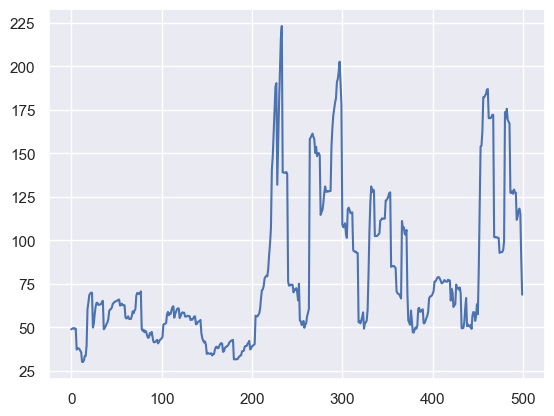

In [256]:
plt.plot(nrjlist)

# Comparaison avec d'autres modèles (baseline UDE / DSVD)

In [99]:
arrfullup1, arrfullpred1 = np.load('data/arrfullup1UDE.npy'), np.load('data/arrfullpred1UDE.npy')

In [100]:
print(arrfullpred1.shape)

(500, 740, 36, 2)


In [102]:
np.mean([energy_score_nd(data_arr[p, :36, :2], arrfullpred1[:20, p, :, :]) for p in range(740)])

12.066974812352571

In [156]:
# Energy score UDE formula

# First retrieve for every time of the month, all the realization of this time in the generated forecasts and simulations (500 x Nb trains) --> padding

N, sh1, sh2, sh3 = arrfullpred1.shape

res = np.zeros((N, sh1, sh1+sh2, sh3))
    
for k in range(sh1):
    res[:, k, k:k+sh2, :] = arrfullpred1[:, k]

ind = [int(max(0, p-36)) for p in range(740)]

# Then compute
np.mean([energy_score_UDE(obs_arr[p, :2], res[:, ind[p]:p, p, :].reshape((-1, 2))) for p in range(1, 740)])

6.97900825962333

In [177]:
ind = [int(max(0, p-35)) for p in range(740)]

# Then compute
np.mean([energy_score_UDE(obs_arr[p+1, :1], res[:30, ind[p]:p, p, :1].reshape((-1, 2))) for p in range(1, 740)])

4.408109925683506

In [43]:
# Energy score UDE bis formula

# First retrieve for every time of the month, all the realization of this time in the generated forecasts and simulations (10 x Nb trains) --> padding
tryb = np.array(trylist)[:, :, :36, :2]

N, sh1, sh2, sh3 = tryb.shape

res = np.zeros((N, sh1, sh1+sh2, sh3))
    
for k in range(sh1):
    res[:, k, k:k+sh2, :] = tryb[:, k]

ind = [int(max(0, p-36)) for p in range(740)]

# Then compute
np.mean([energy_score_UDE_BIS(res[0, p, p, :], res[:, ind[p]:p, p, :]) for p in range(1, 740)])


56.94093880753442

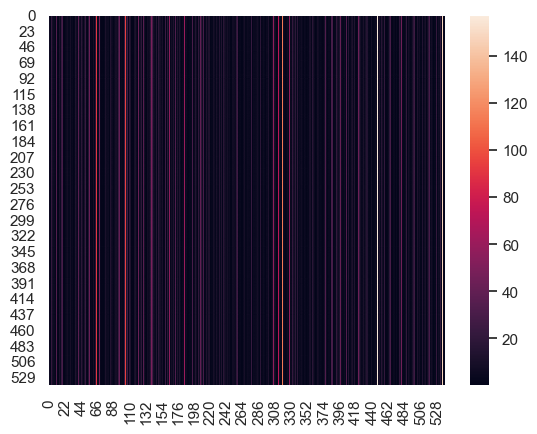

278.4352662501162

In [106]:
MiVo(upbig_scaled[:540, :36, 0], arrfullup1[0, :540, :, 0])

# KFold cross validation strategy

In [17]:
from sklearn.model_selection import KFold

In [28]:
kf = KFold(n_splits=10)

def cv_load_power(data, batch_size=128, stack=False):

    #train_df = data[:int(0.8*len(data))]
    #test_df = data[int(0.8*len(data)):]
    #train_df, test_df = train_test_split(data, test_size=0.2)
    train, test = [], []
    for train_i, test_i in kf.split(data):
        train_loader = DataLoader(Power(data[train_i], stack=stack), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
        test_loader = DataLoader(Power(data[test_i], stack=stack), batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False, drop_last=True)

        train.append(train_loader)
        test.append(test_loader)

    return train, test#, n_stations, n_window

In [42]:
train, test = cv_load_power(upbig_scaled, 16)
input = next(iter(train[0]))
print(input.shape, len(train), len(train[0]))

torch.Size([16, 45, 5]) 10 89


In [43]:
def cv_train_model(trainlist, testlist, model_name="Copula", hparams=None, opt_hparams=odict, n_epochs=50):
    list_model, list_errtr, list_errte = [], [], []
    for train_loader, test_loader in zip(trainlist, testlist):
        model, errtr, errte = train_model(train_loader, test_loader, model_name, hparams, opt_hparams, n_epochs)
        list_model.append(model)
        list_errtr.append(errtr)
        list_errte.append(errte)
   
    return list_model, list_errtr, list_errte

100%|██████████| 50/50 [08:49<00:00, 10.59s/it]


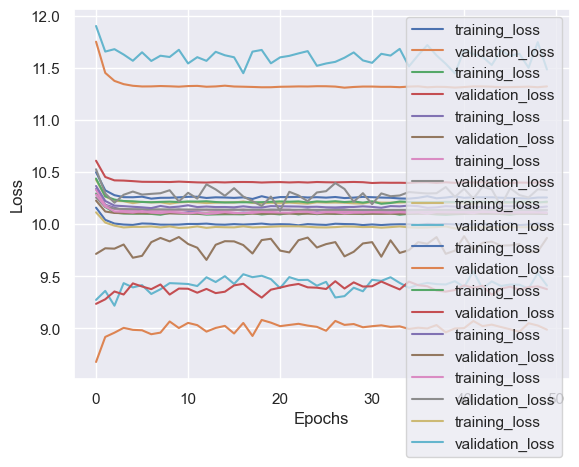

In [45]:
rescv = cv_train_model(train, test)

In [77]:
list_model_gp, list_errtr_gp, list_errte_gp = rescv

In [187]:
gen_model = [] # save some scenarios to plot
nrj_scores = []
var_scores = []

for k in range(10):
    print(k, "start")
    model = list_model_gp[k]
    # For each trained copula model, generate 100 scenarii
    trylist = gen_traj(trained_model=model, n_scenarios=10)
    print("generation done")
    gen_model.append(trylist)

    # Compute the energy score for each month (30*24h=720h)
    nrjlist = []
    i = 0
    while i < 7990:
        nrjlist.append(np.mean([energy_score_nd(data_arr[p, :45, :], np.array(trylist)[:, p, :, :]) for p in range(i, i+720)]))
        i += 720
    
    nrj_scores.append(nrjlist)
    print("energy score done")

    # Compute the spatial variogram score for each month (30*24h=720h)
    varlist = []
    i = 0
    while i < 7990:
        varlist.append(np.mean([variogram_score_spatial(data_arr[p, :45, :], np.array(trylist)[:, p, :, :]) for p in range(i, i+720)]))
        i += 720
    
    var_scores.append(varlist)
    print("variogram score done")
    print("\n")
    

0 start
generation done
energy score done
variogram score done


1 start
generation done
energy score done
variogram score done


2 start
generation done
energy score done
variogram score done


3 start
generation done
energy score done
variogram score done


4 start
generation done
energy score done
variogram score done


5 start
generation done
energy score done
variogram score done


6 start
generation done
energy score done
variogram score done


7 start
generation done
energy score done
variogram score done


8 start
generation done
energy score done
variogram score done


9 start
generation done
energy score done
variogram score done




In [191]:
print([np.mean(nrj_scores[k]) for k in range(10)])

[12.907701806432973, 12.924956017647103, 12.922899267173657, 12.945427831512992, 12.914892713798025, 12.920849603185417, 12.923473646321389, 12.87924880407172, 12.909488729139957, 12.849861519349576]


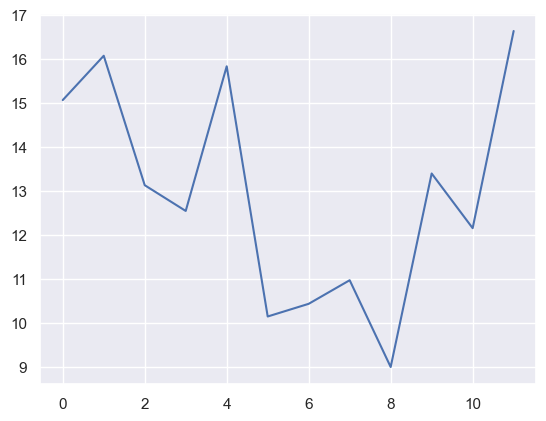

In [188]:
plt.plot(nrj_scores[3])

generation done
energy score done
variogram score done


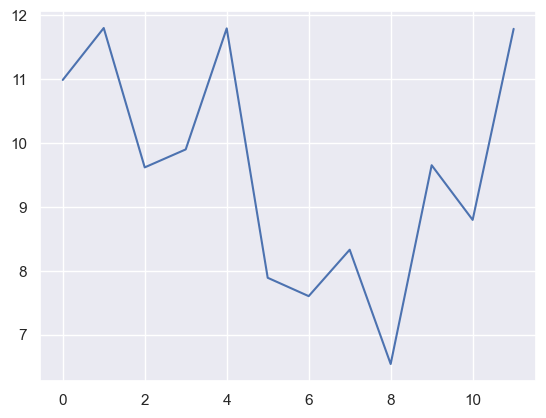

In [193]:
# for 2 nodes
k = 9
model = list_model_gp[k]
# For each trained copula model, generate 100 scenarii
trylist = gen_traj(trained_model=model, n_scenarios=10)
print("generation done")
gen_model.append(trylist)

# Compute the energy score for each month (30*24h=720h)
nrjlistb = []
i = 0
while i < 7990:
    nrjlistb.append(np.mean([energy_score_nd(data_arr[p, :36, :2], np.array(trylist)[:, p, :36, :2]) for p in range(i, i+720)]))
    i += 720

print("energy score done")
plt.plot(nrjlistb)

# Compute the spatial variogram score for each month (30*24h=720h)
varlistb = []
i = 0
while i < 7990:
    varlistb.append(np.mean([variogram_score_spatial(data_arr[p, :36, :2], np.array(trylist)[:, p, :36, :2]) for p in range(i, i+720)]))
    i += 720

print("variogram score done")


    